In [1]:
cd ../../../src

/Users/cock/kDrive/PhD/Projects/Labs/blind-mitigation/src


In [32]:
import os
import yaml
import pickle

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from data_handlers.data_loader import DataLoader

# Functions


In [3]:
def aggregate(sequence:list, keys:list, states:list, actions:list):
    """
    Takes the sequence of actions with len(states) states and len(actions) actions, and creates a vector
    with the aggregated time and n_states x n_actions features.
    
    Args:
        sequence [list]: the vector containing the students action, where each list in the sequence has a 1 in 
        the first n_states entry, and a number > 0 in the last n_actions entry, and where the rest is zero
        keys [list]: vector of the known aggregated features (each entry in the form {indexstate}_{indexaction})
        states [list]: states in the features
        actions [list]: actions in the features
    """
    n_states = len(states)
    n_actions = len(actions)
    new_sequences = {k:0 for k in keys}
    for vector in sequence:
        index_state = np.argmax(vector[0:n_states])
        index_action = np.argmax(vector[-n_actions:])
        action_time = vector[n_states + index_action]
        state = states[index_state]
        action = actions[index_action]
        
        new_sequences['{}_{}'.format(state, action)] += action_time
    return new_sequences

In [4]:
def get_colour(n:int) -> str:
    """Returns n colours from the chosen palette

    Args:
        n (int): number of colours wanted

    Returns:
        list: n randomly chosen colours. If n > len(palette) -> some colours will be selected more than
        once
    """
    colours = [
        '#241A7A', '#7A89F7', '#AFB9FA', '#EFF3F6', '#EF8C34',
        '#594DD4', '#213AF2', '#A8BCC7', '#A8BCC7', '#A8BCC7', 
        '#618595', '#618595'
    ]
    replace_bool = n > len(colours)
    return np.random.choice(colours, size=n, replace=replace_bool)

# Data

In [5]:
# Preparation of the stucture
states = [
    'greengreen',
    'greenred',
    'notgreennotred',
    'noobserved'
]
actions = [
    'other',
    'concentration', 
    'width', 
    'concentrationlab',
    'pdf',
    'break'
]

keys = []
for s in states:
    for a in actions:
        keys.append('{}_{}'.format(s, a))
        

In [6]:
# Prepation of the data
with open('./configs/oversample_config.yaml', 'r') as f:
    settings = yaml.load(f, Loader=yaml.FullLoader)
    
dl = DataLoader(settings)
sequences, labels, demographics = dl.load_data()
new_sequences = []
for seq in sequences:
    new_seq = aggregate(seq, keys, states, actions)
    new_sequences.append(new_seq)

# PCA

In [7]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [8]:
def prepare_data(sequences:list, keys:list):
    """
    Takes the sequences where each data point is represented by a dictionary, where the key is the name
    of the feature, and the value is the time spent on that feature. Then, it transforms it into a list with just 
    the time spent on that feature
    
    Args:
        sequences [list]: list of data points, where each data point is a dictionary.
        keys [list]: ordered list of the features to create the new sequences
        
    Returns:
        new_sequences [list] new list of features
    """
    new_sequences = []
    for seq in sequences:
        new_sequences.append([seq[k] for k in keys])
    return new_sequences

In [9]:
formatted_data = prepare_data(new_sequences, keys)

In [10]:
pca = PCA(n_components=3)
pca_sequences = pca.fit_transform(formatted_data)
print(pca.explained_variance_)

[6.60093453 3.49740244 2.64536335]


<IPython.core.display.Javascript object>


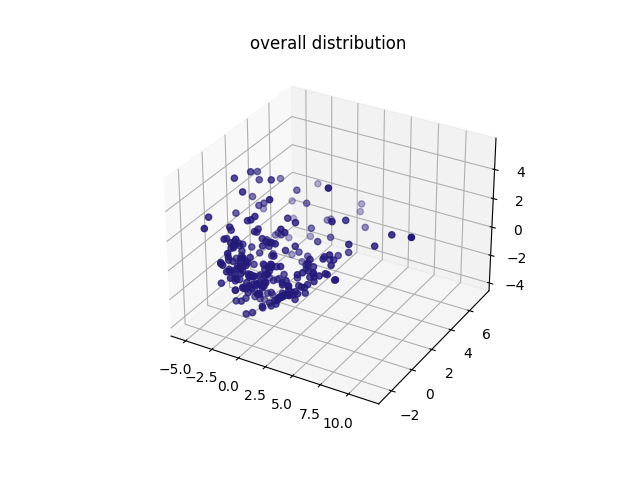

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=[pca_seq[0] for pca_seq in pca_sequences], 
    ys=[pca_seq[1] for pca_seq in pca_sequences], 
    zs=[pca_seq[2] for pca_seq in pca_sequences],
    color=get_colour(1))
plt.title('overall distribution')
# plt.legend()
plt.show()

<IPython.core.display.Javascript object>


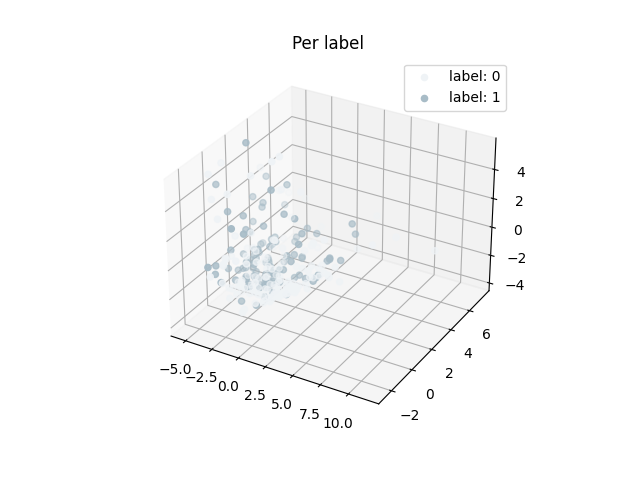

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
unique_labels = list(np.unique(labels))
colours = get_colour(len(unique_labels))
for l, label in enumerate(unique_labels):
    lab_indices = [i for i in range(len(labels)) if labels[i] == label]
    lab_sequences = [pca_sequences[i] for i in lab_indices]
    ax.scatter(
        xs=[pca_seq[0] for pca_seq in lab_sequences], 
        ys=[pca_seq[1] for pca_seq in lab_sequences], 
        zs=[pca_seq[2] for pca_seq in lab_sequences],
        color=colours[l], label='label: {}'.format(label), zdir='y')
plt.title('Per label')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


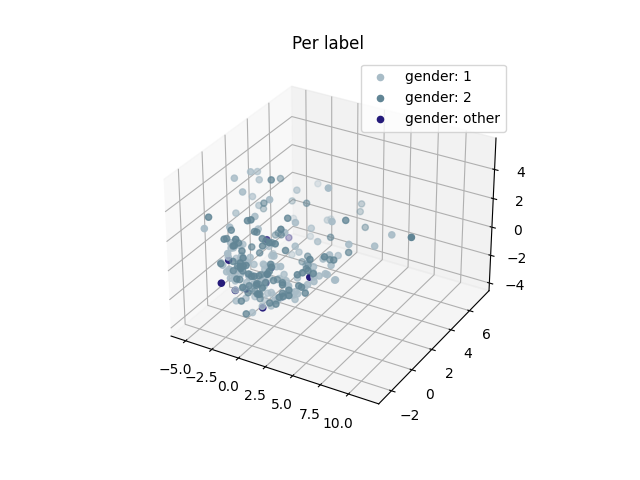

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
unique_demographics = list(np.unique(demographics['gender']))
colours = get_colour(len(unique_demographics))
for l, label in enumerate(unique_demographics):
    lab_indices = [i for i in range(len(labels)) if demographics['gender'][i] == label]
    lab_sequences = [pca_sequences[i] for i in lab_indices]
    ax.scatter(
        xs=[pca_seq[0] for pca_seq in lab_sequences], 
        ys=[pca_seq[1] for pca_seq in lab_sequences], 
        zs=[pca_seq[2] for pca_seq in lab_sequences],
        color=colours[l], label='gender: {}'.format(label), zdir='z')
plt.title('Per label')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


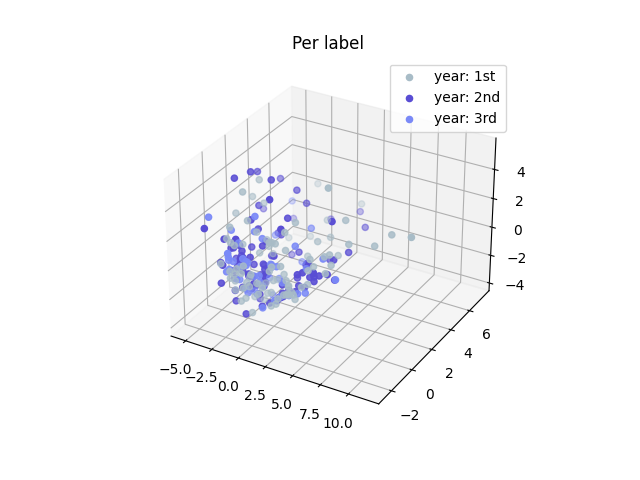

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
unique_demographics = list(np.unique(demographics['year']))
colours = get_colour(len(unique_demographics))
for l, label in enumerate(unique_demographics):
    lab_indices = [i for i in range(len(labels)) if demographics['year'][i] == label]
    lab_sequences = [pca_sequences[i] for i in lab_indices]
    ax.scatter(
        xs=[pca_seq[0] for pca_seq in lab_sequences], 
        ys=[pca_seq[1] for pca_seq in lab_sequences], 
        zs=[pca_seq[2] for pca_seq in lab_sequences],
        color=colours[l], label='year: {}'.format(label), zdir='z')
plt.title('Per label')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


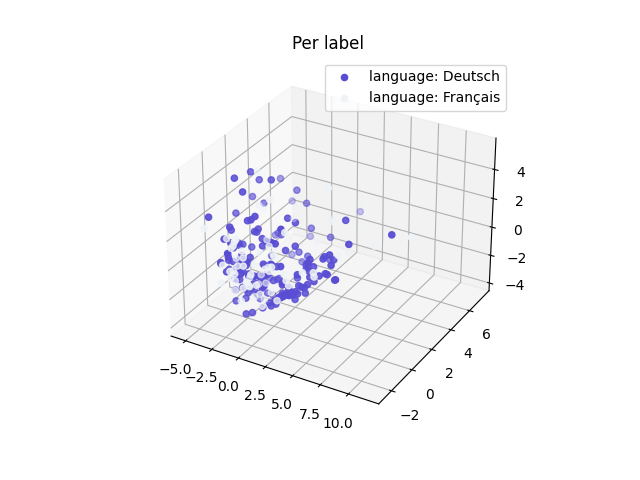

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
unique_demographics = list(np.unique(demographics['language']))
colours = get_colour(len(unique_demographics))
for l, label in enumerate(unique_demographics):
    lab_indices = [i for i in range(len(labels)) if demographics['language'][i] == label]
    lab_sequences = [pca_sequences[i] for i in lab_indices]
    ax.scatter(
        xs=[pca_seq[0] for pca_seq in lab_sequences], 
        ys=[pca_seq[1] for pca_seq in lab_sequences], 
        zs=[pca_seq[2] for pca_seq in lab_sequences],
        color=colours[l], label='language: {}'.format(label), zdir='z')
plt.title('Per label')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


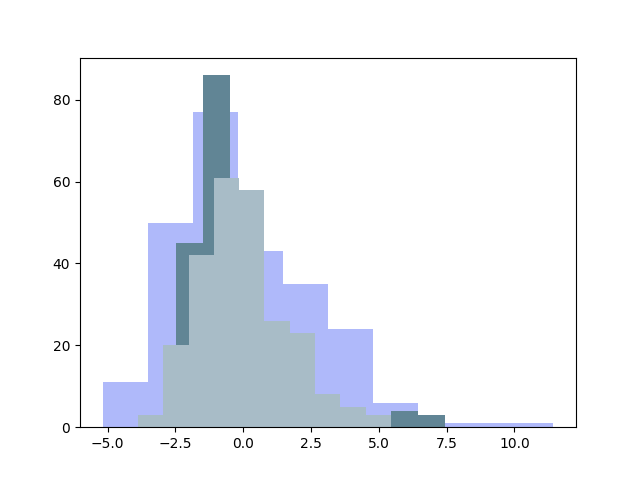

In [16]:
colours = get_colour(3)
for i, c in enumerate(colours):
    plt.hist([pca_seq[i] for pca_seq in pca_sequences], color=c)

## Clustering

In [17]:
from sklearn.cluster import DBSCAN

In [18]:
clustering = DBSCAN(eps=1.5, min_samples=3).fit(pca_sequences)

<IPython.core.display.Javascript object>


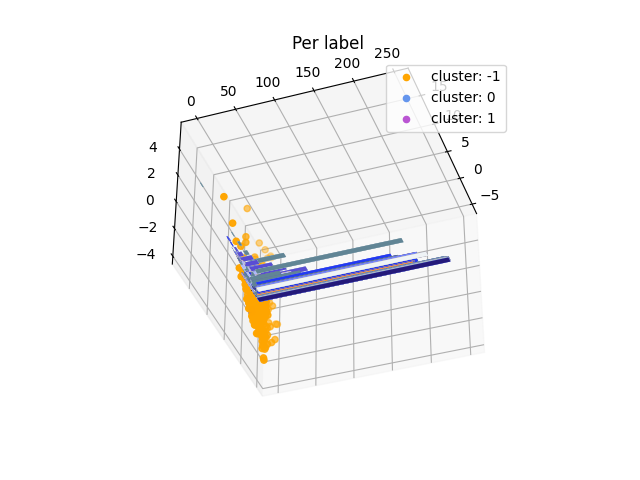

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
unique_demographics = list(np.unique(clustering.labels_))
colours = ['orange', 'cornflowerblue', 'mediumorchid']
for l, label in enumerate(unique_demographics):
    lab_indices = [i for i in range(len(labels)) if clustering.labels_[i] == label]
    lab_sequences = [pca_sequences[i] for i in lab_indices]
    ax.scatter(
        xs=[pca_seq[0] for pca_seq in lab_sequences], 
        ys=[pca_seq[1] for pca_seq in lab_sequences], 
        zs=[pca_seq[2] for pca_seq in lab_sequences],
        color=colours[l], label='cluster: {}'.format(label), zdir='z')
plt.title('Per label')
plt.legend()
plt.show()

# DBSCAN

<IPython.core.display.Javascript object>


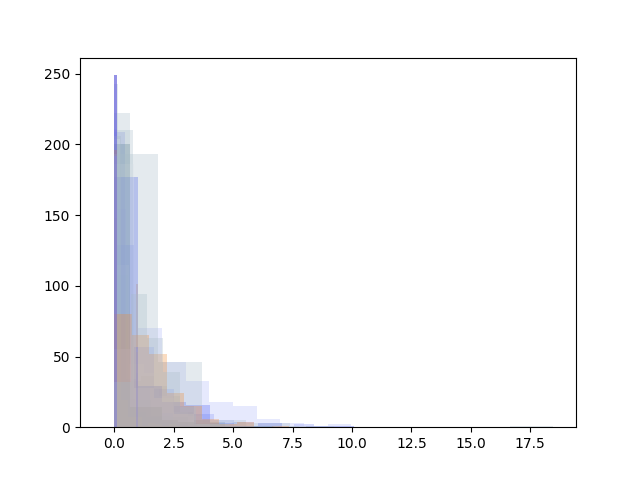

In [13]:
colours = get_colour(24)
for i, c in enumerate(colours):
    plt.hist([format_seq[i] for format_seq in formatted_data], color=c, alpha=0.3)
    plt.show()

In [26]:
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.metrics import silhouette_score
%matplotlib inline

**************************************************
maximum distance to be a neighbour: 0.5
minimum number of samples in a cluster: 2.0
    Silhouette score including noisy samples: -0.19497053096237874
    Silhouette score not including noisy samples: 0.8835850798769151


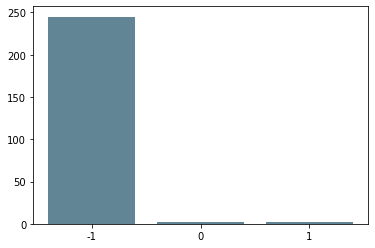

**************************************************
maximum distance to be a neighbour: 1.0
minimum number of samples in a cluster: 2.0
    Silhouette score including noisy samples: -0.22321488970541942
    Silhouette score not including noisy samples: 0.4688553858539032


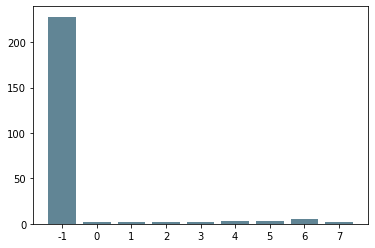

**************************************************
maximum distance to be a neighbour: 1.5
minimum number of samples in a cluster: 4.0
    Silhouette score including noisy samples: -0.18921219419797972
    Silhouette score not including noisy samples: 0.4662805404104845


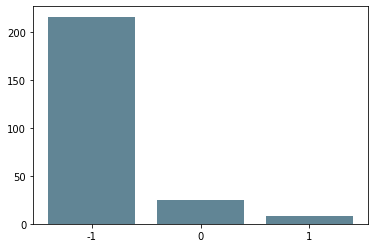

**************************************************
maximum distance to be a neighbour: 1.0
minimum number of samples in a cluster: 3.0
    Silhouette score including noisy samples: -0.20031005874115043
    Silhouette score not including noisy samples: 0.4567078555355888


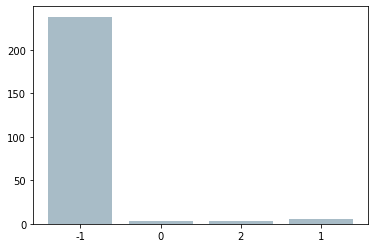

**************************************************
maximum distance to be a neighbour: 1.5
minimum number of samples in a cluster: 5.0
    Silhouette score including noisy samples: -0.20429639173410338
    Silhouette score not including noisy samples: 0.4513757742675024


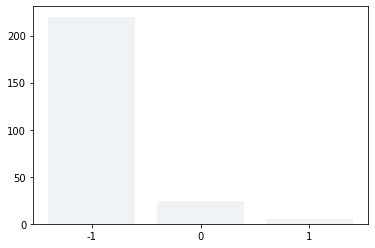

**************************************************
maximum distance to be a neighbour: 5.0
minimum number of samples in a cluster: 2.0
    Silhouette score including noisy samples: 0.4065141254635761
    Silhouette score not including noisy samples: 0.4300538437588147


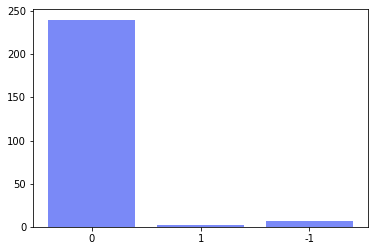

**************************************************
maximum distance to be a neighbour: 2.0
minimum number of samples in a cluster: 9.0
    Silhouette score including noisy samples: -0.10581417372508728
    Silhouette score not including noisy samples: 0.3426060021493926


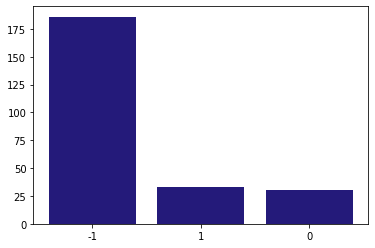

**************************************************
maximum distance to be a neighbour: 2.0
minimum number of samples in a cluster: 8.0
    Silhouette score including noisy samples: -0.10233647294580697
    Silhouette score not including noisy samples: 0.3396617016809924


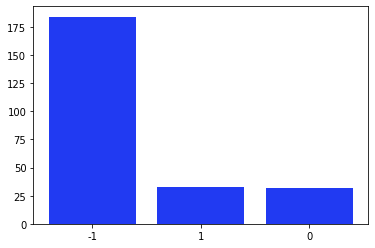

**************************************************
maximum distance to be a neighbour: 2.0
minimum number of samples in a cluster: 6.0
    Silhouette score including noisy samples: -0.07640589309774813
    Silhouette score not including noisy samples: 0.3315834012705871


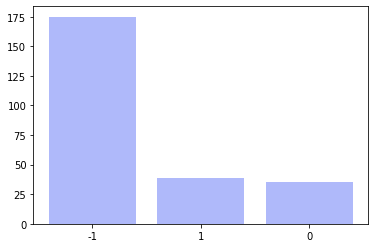

**************************************************
maximum distance to be a neighbour: 2.0
minimum number of samples in a cluster: 7.0
    Silhouette score including noisy samples: -0.08234985176395562
    Silhouette score not including noisy samples: 0.33125089292085413


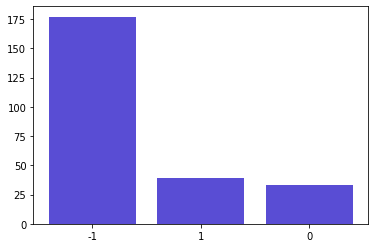

**************************************************
maximum distance to be a neighbour: 3.5
minimum number of samples in a cluster: 3.0
    Silhouette score including noisy samples: 0.1977893266074193
    Silhouette score not including noisy samples: 0.3025007544570128


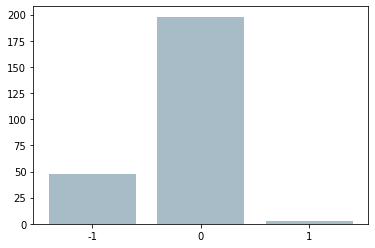

**************************************************
maximum distance to be a neighbour: 1.5
minimum number of samples in a cluster: 3.0
    Silhouette score including noisy samples: -0.22923877831093742
    Silhouette score not including noisy samples: 0.28296233405279975


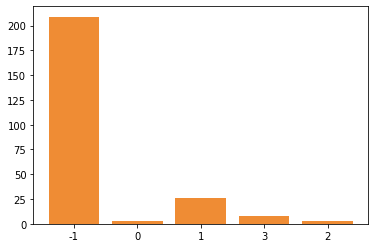

**************************************************
maximum distance to be a neighbour: 1.5
minimum number of samples in a cluster: 2.0
    Silhouette score including noisy samples: -0.24245780209977347
    Silhouette score not including noisy samples: 0.25389346475857133


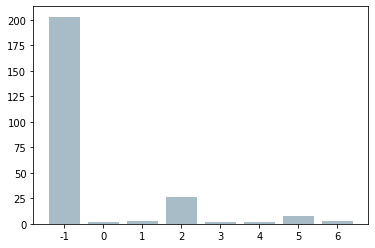

**************************************************
maximum distance to be a neighbour: 3.5
minimum number of samples in a cluster: 2.0
    Silhouette score including noisy samples: 0.10563317046226979
    Silhouette score not including noisy samples: 0.1921048280577063


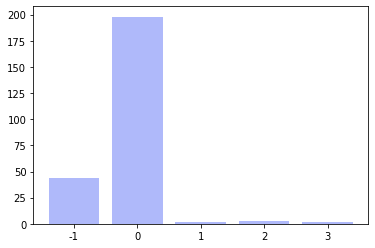

**************************************************
maximum distance to be a neighbour: 2.5
minimum number of samples in a cluster: 3.0
    Silhouette score including noisy samples: -0.003144606497345684
    Silhouette score not including noisy samples: 0.17736975035551794


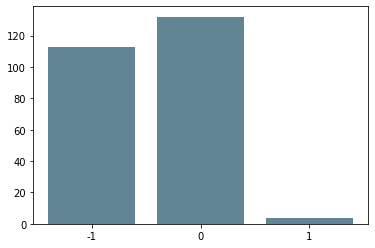

**************************************************
maximum distance to be a neighbour: 2.0
minimum number of samples in a cluster: 3.0
    Silhouette score including noisy samples: -0.131528392215148
    Silhouette score not including noisy samples: 0.14342277923163557


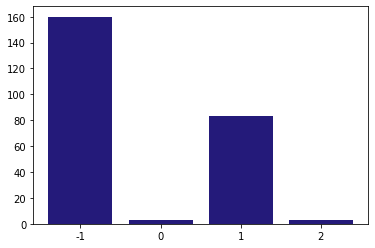

**************************************************
maximum distance to be a neighbour: 3.0
minimum number of samples in a cluster: 2.0
    Silhouette score including noisy samples: 0.03167785363368725
    Silhouette score not including noisy samples: 0.14155251038117045


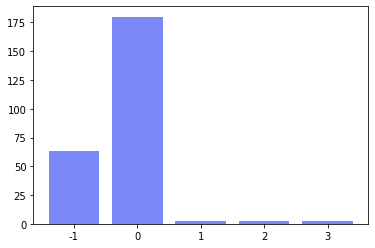

**************************************************
maximum distance to be a neighbour: 2.5
minimum number of samples in a cluster: 2.0
    Silhouette score including noisy samples: -0.059310291245471165
    Silhouette score not including noisy samples: 0.11656811261136293


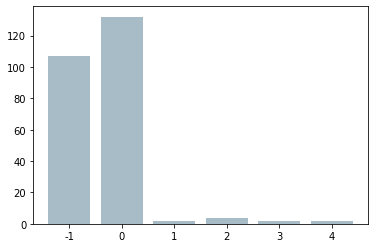

**************************************************
maximum distance to be a neighbour: 2.0
minimum number of samples in a cluster: 2.0
    Silhouette score including noisy samples: -0.22320305381734387
    Silhouette score not including noisy samples: -0.05705090005650023


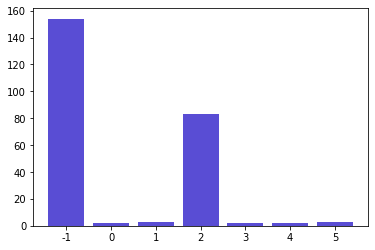

In [33]:
scores = []
for eps in np.arange(0.5, 10, 0.5):
    for min_samples in range(2, 10):
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(formatted_data)
        cluster_labels = Counter(clustering.labels_)
        
        non_noisy = [i for i in range(len(clustering.labels_)) if clustering.labels_[i] != -1]
        non_noisy_data = [formatted_data[idx] for idx in non_noisy]
        non_noisy_labels = [clustering.labels_[idx] for idx in non_noisy]
        if len(non_noisy) == 0 or len(np.unique(clustering.labels_)) < 2:
#             print('    No valid clusters')
            continue
        else:
            try:
                scores.append([
                    eps, 
                    min_samples,
                    silhouette_score(non_noisy_data, non_noisy_labels),
                    silhouette_score(formatted_data, clustering.labels_)
                    ])
            except ValueError:
                continue

        
scores_df = pd.DataFrame(scores)
scores_df.columns = ['eps', 'min_samples', 'non_noisy_silhouette', 'noisy_silhouette']
scores_df = scores_df.sort_values(['non_noisy_silhouette', 'noisy_silhouette'], ascending=False)
for i, row in scores_df.iterrows():
    print('*'*50)
    print('maximum distance to be a neighbour: {}'.format(row['eps']))
    print('minimum number of samples in a cluster: {}'.format(row['min_samples']))
    print('    Silhouette score including noisy samples: {}'.format(
        row['noisy_silhouette'])
         )
    print('    Silhouette score not including noisy samples: {}'.format(
        row['non_noisy_silhouette'])
         )
    clustering = DBSCAN(eps=row['eps'], min_samples=row['min_samples']).fit(formatted_data)
    cluster_labels = Counter(clustering.labels_)
    plt.bar(range(len(cluster_labels)), cluster_labels.values(), color=get_colour(1))
    plt.xticks(range(len(cluster_labels)), cluster_labels.keys())
    plt.show()

In [34]:
for distance in [0.3, 0.4, 0.5, 0.7, 1, 1.5, 2, 2.5, 3]:
    for min_samples in range(5):
        print('* ' * 50)
        print('parameters')
        print('    distance: {}'.format(distance))
        print('    samples: {}'.format(min_samples))
        
        clustering = DBSCAN(eps=2, min_samples=3).fit(formatted_data)
        non_noisy = [i for i in range(len(clustering.labels_)) if clustering.labels_[i] != -1]
        non_noisy_data = [formatted_data[idx] for idx in non_noisy]
        non_noisy_labels = [clustering.labels_[idx] for idx in non_noisy]
        if len(non_noisy) == 0:
            print('    No valid clusters')
        else:
            print('    Silhouette score including noisy samples: {}'.format(
                silhouette_score(formatted_data, clustering.labels_))
                 )
            print('    Silhouette score not including noisy samples: {}'.format(
                silhouette_score(non_noisy_data, non_noisy_labels))
                 )

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
parameters
    distance: 0.3
    samples: 0
    Silhouette score including noisy samples: -0.131528392215148
    Silhouette score not including noisy samples: 0.14342277923163557
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
parameters
    distance: 0.3
    samples: 1
    Silhouette score including noisy samples: -0.131528392215148
    Silhouette score not including noisy samples: 0.14342277923163557
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
parameters
    distance: 0.3
    samples: 2
    Silhouette score including noisy samples: -0.131528392215148
    Silhouette score not including noisy samples: 0.14342277923163557
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
parameters
    distance: 0.3
    samples: 3
    Silhouette 